# Personal Info

### Name: `Mohammad Parsa Dini`

Student Number: `400101204`

# Introduction

* Importing libraries

* Helper functions

* Plotting functions

* Set seed and set device

## Libraries

First, let's download the necessary libraries that are used throughout the assignment.

In [1]:
import time
import torch
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange
from PIL import Image
import requests, os
import random

if torch.cuda.is_available():
    torch.device = 'cuda'
else:
    torch.device = 'cpu'

print(torch.device)

cuda


## Helper Functioins

In [2]:
from scipy.signal import correlate2d
import zipfile, gzip, shutil, tarfile


def download_data(fname, folder, url, tar):
  """
  Data downloading from OSF.

  Args:
    fname : str
      The name of the archive
    folder : str
      The name of the destination folder
    url : str
      The download url
    tar : boolean
      `tar=True` the archive is `fname`.tar.gz, `tar=False` is `fname`.zip

  Returns:
    Nothing.
  """

  if not os.path.exists(folder):
    print(f'\nDownloading {folder} dataset...')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)
    print(f'\nDownloading {folder} completed.')

    print('\nExtracting the files...\n')
    if not tar:
      with zipfile.ZipFile(fname, 'r') as fz:
        fz.extractall()
    else:
      with tarfile.open(fname) as ft:
        ft.extractall()
    # Remove the archive
    os.remove(fname)

    # Extract all .gz files
    foldername = folder + '/raw/'
    for filename in os.listdir(foldername):
      # Remove the extension
      fname = filename.replace('.gz', '')
      # Gunzip all files
      with gzip.open(foldername + filename, 'rb') as f_in:
        with open(foldername + fname, 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)
          os.remove(foldername+filename)
  else:
    print(f'{folder} dataset has already been downloaded.\n')


def test(model, device, data_loader):
  """
  Test function

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.
    data_loader: torch.loader
      Test loader

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

## Plotting Functions

In [3]:
def display_image_from_greyscale_array(matrix, title):
  """
  Display image from greyscale array

  Args:
    matrix: np.ndarray
      Image
    title: string
      Title of plot

  Returns:
    Nothing
  """
  _matrix = matrix.astype(np.uint8)
  _img = Image.fromarray(_matrix, 'L')
  plt.figure(figsize=(3, 3))
  plt.imshow(_img, cmap='gray', vmin=0, vmax=255) # Using 220 instead of 255 so the examples show up better
  plt.title(title)
  plt.axis('off')


def make_plots(original, actual_convolution, solution):
  """
  Function to build original image/obtained solution and actual convolution

  Args:
    original: np.ndarray
      Image
    actual_convolution: np.ndarray
      Expected convolution output
    solution: np.ndarray
      Obtained convolution output

  Returns:
    Nothing
  """
  display_image_from_greyscale_array(original, "Original Image")
  display_image_from_greyscale_array(actual_convolution, "Convolution result")
  display_image_from_greyscale_array(solution, "Your solution")


def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):
  """
  Code to plot loss and accuracy

  Args:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy

  Returns:
    Nothing
  """
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)

## Set Random Seed and Set Device

In [4]:
# For DL it's important to set the random seed so that you can have a
# baseline to compare your results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [2]:
# using this function, you can be informed whether the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [5]:
SEED = 1404
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 1404 has been set.
GPU is enabled in this notebook.


In [7]:
import torchvision

# Seed worker function for reproducibility in DataLoader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    torch.manual_seed(worker_seed)

# Provided function: Load EMNIST dataset with only O (15) and X (24)
def get_Xvs0_dataset(normalize=False, download=False):
    """
    Load Dataset

    Args:
        normalize: boolean
            If true, normalise dataloader
        download: boolean
            If true, download dataset

    Returns:
        emnist_train: torch.loader
            Training Data
        emnist_test: torch.loader
            Test Data
    """
    if normalize:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    emnist_train = torchvision.datasets.EMNIST(root='.',
                                               split='letters',
                                               download=download,
                                               train=True,
                                               transform=transform)
    emnist_test = torchvision.datasets.EMNIST(root='.',
                                              split='letters',
                                              download=download,
                                              train=False,
                                              transform=transform)

    # Only want O (15) and X (24) labels
    train_idx = (emnist_train.targets == 15) | (emnist_train.targets == 24)
    emnist_train.targets = emnist_train.targets[train_idx]
    emnist_train.data = emnist_train.data[train_idx]

    # Convert Xs predictions to 1, Os predictions to 0
    emnist_train.targets = (emnist_train.targets == 24).type(torch.int64)

    test_idx = (emnist_test.targets == 15) | (emnist_test.targets == 24)
    emnist_test.targets = emnist_test.targets[test_idx]
    emnist_test.data = emnist_test.data[test_idx]

    # Convert Xs predictions to 1, Os predictions to 0
    emnist_test.targets = (emnist_test.targets == 24).type(torch.int64)

    return emnist_train, emnist_test

# Provided function: Create data loaders
def get_data_loaders(train_dataset, test_dataset, batch_size=32, seed=0):
    """
    Helper function to fetch dataloaders

    Args:
        train_dataset: torch.tensor
            Training data
        test_dataset: torch.tensor
            Test data
        batch_size: int
            Batch Size
        seed: int
            Set seed for reproducibility

    Returns:
        train_loader: torch.loader
            Training Data
        test_loader: torch.loader
            Test Data
    """
    g_seed = torch.Generator()
    g_seed.manual_seed(seed)

    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=0,  # Disable multiprocessing
                              generator=g_seed)
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=0,  # Disable multiprocessing
                             generator=g_seed)

    return train_loader, test_loader

# Load the dataset
train_dataset, test_dataset = get_Xvs0_dataset(normalize=True, download=True)

# Create data loaders
batch_size = 32
train_loader, test_loader = get_data_loaders(train_dataset, test_dataset, batch_size=batch_size, seed=0)

# Function to extract data shapes (similar to your original code)
def print_dataset_info(dataset, loader, name="Dataset"):
    data_shape = dataset.data.shape
    labels_shape = dataset.targets.shape
    print(f"{name} data shape: {data_shape}")
    print(f"{name} labels shape: {labels_shape}")
    # Count unique labels
    unique_labels = torch.unique(dataset.targets).numpy()
    print(f"{name} unique labels: {unique_labels}")

# Print dataset information
print("Dataset Info:")
print_dataset_info(train_dataset, train_loader, "Training")
print_dataset_info(test_dataset, test_loader, "Test")

# Optionally, verify a batch from the loader
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break

Dataset Info:
Training data shape: torch.Size([9600, 28, 28])
Training labels shape: torch.Size([9600])
Training unique labels: [0 1]
Test data shape: torch.Size([1600, 28, 28])
Test labels shape: torch.Size([1600])
Test unique labels: [0 1]
Batch images shape: torch.Size([32, 1, 28, 28])
Batch labels shape: torch.Size([32])


# Reminder and a sample of training loop

In [9]:
def train(model, device, train_loader, epochs):
  """
  Training function

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    train_loader: torch.loader
      Training Set
    epochs: int
      Number of epochs

  Returns:
    Nothing
  """
  model.train()

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
  for epoch in range(epochs):
    with tqdm(train_loader, unit='batch') as tepoch:
      for data, target in tepoch:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        tepoch.set_postfix(loss=loss.item())
        time.sleep(0.1)


class EMNIST_Net(nn.Module):
  """
  Neural network instance with following structure
  # Convolutional Layer 1: 1 --> 32, kernel_size=3
  # Convolutional Block 2: 32 --> 64, kernel_size=3 + maxpooling
  # Fully Connected Layer 1: 9216 --> 128
  # Fully Connected Layer 2: 128 --> 2
  """

  def __init__(self):
    """
    Initialize parameters of EMNISTNet

    Args:
      None

    Returns:
      Nothing
    """
    super(EMNIST_Net, self).__init__()


    ####################################################################
    # TODO:
    # 1) Define the required layers according to the given structure


    # 1)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.fc1 = nn.Linear(in_features=64*12*12, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=2)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    """
    Forward pass of EMNISTNet

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output of final fully connected layer
    """

    ####################################################################
    # TODO:
    # 2) Define forward pass for any input x (don't forget relus)
    # hint --> don't forget to flatten the image when it passes from Convolution Layers to Linear Layers (torch.flatten())


    # 2)
    x = self.conv1(x)
    x = nn.functional.relu(x)
    x = self.conv2(x)
    x = self.pool(x)
    x = torch.flatten(x,1)
    x = self.fc1(x)
    x = nn.functional.relu(x)
    x = self.fc2(x)
    return x


emnist_net = EMNIST_Net().to(DEVICE)
print("Total Parameters in Network {:10d}".format(sum(p.numel() for p in emnist_net.parameters())))
train(emnist_net, DEVICE, train_loader, 1)

print(f'Test accuracy is: {test(emnist_net, DEVICE, test_loader)}')

Total Parameters in Network    1198850


  0%|          | 0/300 [00:00<?, ?batch/s]

Test accuracy is: 99.125%


# Download Fashion MNIST dataset

* The dataset we are going to use consists of a training set of 60,000 examples and a test set of 10,000 examples.Each example is a 28x28 gray scale image, associated with a label from 10 classes.

* Reducing the dataset to just the two categories (T-shirt/top and Shirt) reduces the training time to about 2 minutes.

In [6]:
import os
import requests
import gzip
import shutil
from pathlib import Path
from tqdm import tqdm

def download_fashion_mnist(folder):
    """
    Download and extract Fashion-MNIST dataset to the specified folder.
    
    Args:
        folder (str): Destination folder for the dataset
    """
    # Create the folder if it doesn't exist
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    # Base URL for Fashion-MNIST files
    base_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"
    
    # List of files to download
    files = [
        "train-images-idx3-ubyte.gz",
        "train-labels-idx1-ubyte.gz",
        "t10k-images-idx3-ubyte.gz",
        "t10k-labels-idx1-ubyte.gz"
    ]
    
    for file in files:
        file_url = base_url + file
        file_path = os.path.join(folder, file)
        extracted_path = os.path.join(folder, file.replace(".gz", ""))
        
        # Skip if the extracted file already exists
        if os.path.exists(extracted_path):
            print(f"{extracted_path} already exists, skipping download.")
            continue
        
        # Download with progress bar
        print(f"Downloading {file}...")
        try:
            response = requests.get(file_url, stream=True)
            total_size = int(response.headers.get('content-length', 0))
            
            if response.status_code != 200:
                print(f"Failed to download {file}. Status code: {response.status_code}")
                continue
            
            with open(file_path, 'wb') as f, tqdm(
                desc=file,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024
            ) as bar:
                for chunk in response.iter_content(chunk_size=8192):
                    size = f.write(chunk)
                    bar.update(size)
            
            # Extract the .gz file
            print(f"Extracting {file}...")
            with gzip.open(file_path, 'rb') as f_in:
                with open(extracted_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            
            # Remove the .gz file to save space
            os.remove(file_path)
            print(f"Extracted {extracted_path}")
        
        except Exception as e:
            print(f"Error processing {file}: {e}")
            if os.path.exists(file_path):
                os.remove(file_path)

# Usage
folder = 'FashionMNIST/raw'  # Standard path for compatibility with torchvision
download_fashion_mnist(folder)

FashionMNIST/raw\train-images-idx3-ubyte already exists, skipping download.
FashionMNIST/raw\train-labels-idx1-ubyte already exists, skipping download.
FashionMNIST/raw\t10k-images-idx3-ubyte already exists, skipping download.
FashionMNIST/raw\t10k-labels-idx1-ubyte already exists, skipping download.


In [7]:
# need to split into train, validation, test
def reduce_classes(data):
  """
  Reducing Fashion-MNIST Data to two-categories:
    T-Shirts and Shirts

  Args:
    data: torch.tensor
      Training Data

  Returns:
    data: torch.tensor
      Data with two classes
  """
  # Only want T-Shirts (0) and Shirts (6) labels
  train_idx = (data.targets == 0) | (data.targets == 6)
  data.targets = data.targets[train_idx]
  data.data = data.data[train_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  data.targets[data.targets == 6] = 1

  return data


def get_fashion_mnist_dataset(binary=False, download=False, seed=0):
  """
  Helper function to get Fashion MNIST data

  Args:
    binary: boolean
      If True, training data has only two classes
    download: boolean
      If True, download training data
    seed: int
      Set seed for reproducibility [default: 0]

  Returns:
    train_data: torch.tensor
      Training data
    test_data: torch.tensor
      Test data
    validation_data: torch.tensor
      Validation data
  """
  transform = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                                  ])

  train_data = datasets.FashionMNIST(root='.',
                                     download=download,
                                     train=True,
                                     transform=transform)


  test_data = datasets.FashionMNIST(root='.',
                                    download=download,
                                    train=False,
                                    transform=transform)

  if binary:
    train_data = reduce_classes(train_data)
    test_data = reduce_classes(test_data)

  set_seed(seed)
  validation_data, test_data = torch.utils.data.random_split(test_data,
                                                             [int(0.8*len(test_data)),
                                                              int(0.2*len(test_data))])

  return train_data, validation_data, test_data

Visualize the data

In [8]:
#num_classes = 10
#train_data, validation_data, test_data = get_fashion_mnist_dataset(seed=SEED)

# Example of reducing the data into 2 categories
num_classes = 2
train_data, validation_data, test_data = get_fashion_mnist_dataset(binary=True, seed=SEED)

Random seed 1404 has been set.


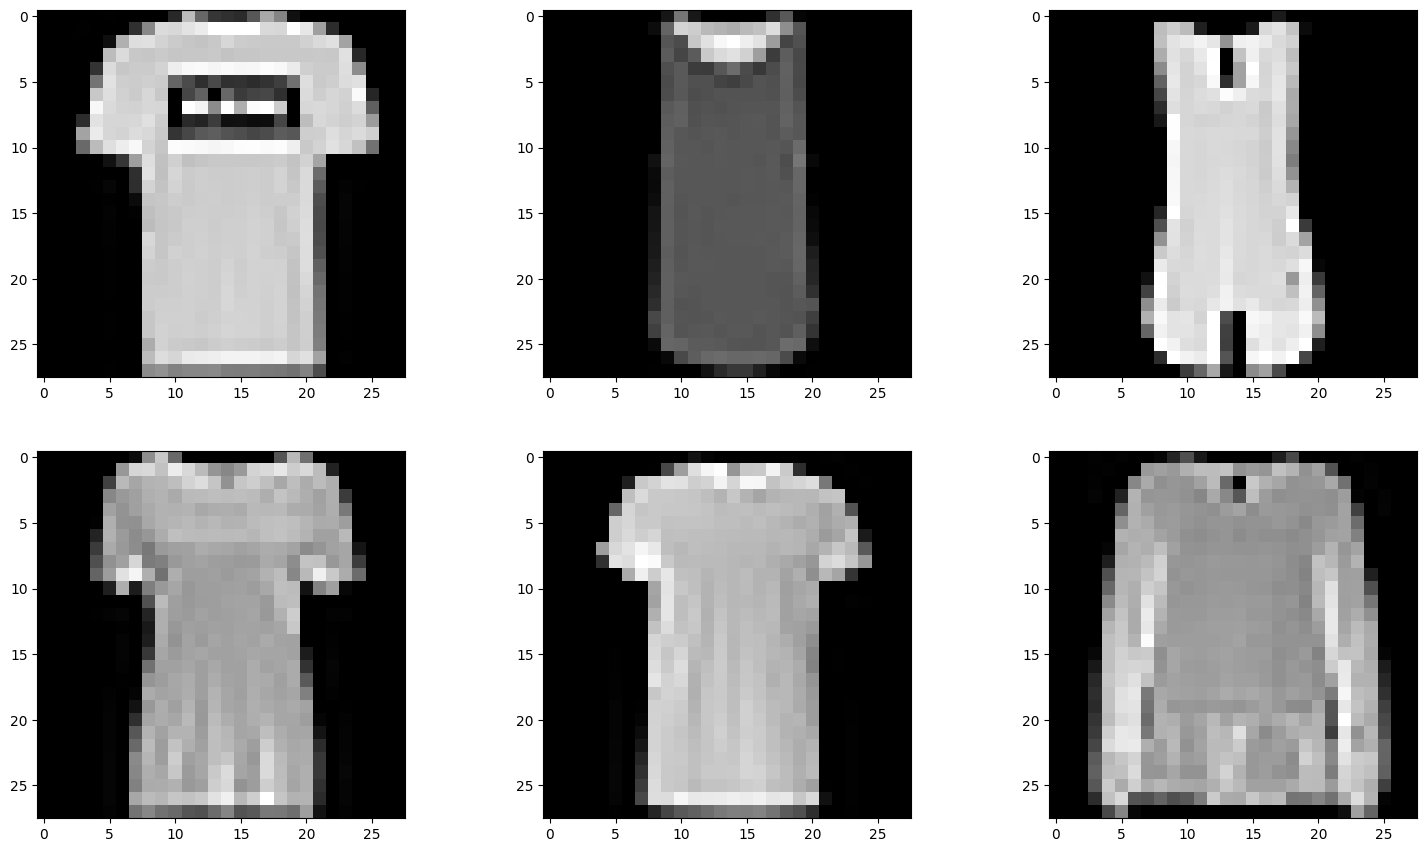

In [9]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 6))
ax1.imshow(train_data[0][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax2.imshow(train_data[1][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax3.imshow(train_data[2][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax4.imshow(train_data[3][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax5.imshow(train_data[4][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax6.imshow(train_data[5][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

# Getting the DataLoaders

In [10]:
# It's good to take a better look at this section so that you also learn to define DataLoaders yourself

def get_data_loaders(train_dataset, validation_dataset,
                     test_dataset, seed,
                     batch_size=64):
  """
  Helper function to fetch dataloaders

  Args:
    train_dataset: torch.tensor
      Training data
    test_dataset: torch.tensor
      Test data
    validation_dataset: torch.tensor
      Validation data
    batch_size: int
      Batch Size  [default: 64]
    seed: int
      Set seed for reproducibility

  Returns:
    train_loader: torch.loader
      Training Data
    test_loader: torch.loader
      Test Data
    validation_loader: torch.loader
      Validation Data
  """

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
  validation_loader = DataLoader(validation_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=2,
                                 worker_init_fn=seed_worker,
                                 generator=g_seed)
  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=2,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

  return train_loader, validation_loader, test_loader


train_loader, validation_loader, test_loader = get_data_loaders(train_data,
                                                                validation_data,
                                                                test_data, SEED)

# Code the training loop

You already coded the structure of a CNN. Now, you are going to implement the training loop for a CNN.

* Choose the correct criterion

* Code the training part (calculating gradients, loss, stepping forward)

* Keep a track of the running loss

In [11]:
class FMNIST_Net1(nn.Module):

  def __init__(self, num_classes):
    """
    Initialise parameters of CNN

    Args:
      num_classes: int
        Number of classes

    Returns:
      Nothing
    """
    super(FMNIST_Net1, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    """

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output after passing through CNN
    """
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    return x

In [12]:
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm

# Set random seed
SEED = 1404

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def clear_dataset_directory(folder):
    """
    Clear the dataset directory to remove potentially corrupted files.
    """
    if os.path.exists(folder):
        shutil.rmtree(folder)
        print(f"Cleared {folder}")
    os.makedirs(folder, exist_ok=True)

def verify_dataset_files(folder):
    """
    Check if required Fashion-MNIST files exist.
    """
    required_files = [
        "train-images-idx3-ubyte",
        "train-labels-idx1-ubyte",
        "t10k-images-idx3-ubyte",
        "t10k-labels-idx1-ubyte"
    ]
    for file in required_files:
        path = os.path.join(folder, file)
        if not os.path.exists(path):
            print(f"Missing: {path}")
            return False
        print(f"Found: {path}")
    return True

def reduce_classes(data):
    """
    Reduce Fashion-MNIST data to two categories: T-Shirts (0) and Shirts (6).
    """
    idx = (data.targets == 0) | (data.targets == 6)
    indices = torch.where(idx)[0]
    data = torch.utils.data.Subset(data, indices)
    mapped_targets = data.dataset.targets[indices].clone()
    mapped_targets[mapped_targets == 6] = 1
    data.dataset.targets[indices] = mapped_targets
    return data

def get_fashion_mnist_dataset(binary=False, download=True, seed=0):
    """
    Get Fashion-MNIST dataset with train, validation, and test splits.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    set_seed(seed)
    
    # Clear dataset directory to ensure clean download
    dataset_root = './FashionMNIST'
    raw_folder = os.path.join(dataset_root, 'raw')
    if not verify_dataset_files(raw_folder):
        print("Dataset files missing or corrupted. Forcing download...")
        clear_dataset_directory(dataset_root)
        download = True

    try:
        train_data = datasets.FashionMNIST(
            root=dataset_root,
            train=True,
            download=download,
            transform=transform
        )
        test_data = datasets.FashionMNIST(
            root=dataset_root,
            train=False,
            download=download,
            transform=transform
        )
    except RuntimeError as e:
        print(f"Dataset loading failed: {e}")
        raise

    print("Dataset loaded successfully!")
    verify_dataset_files(raw_folder)

    if binary:
        train_data = reduce_classes(train_data)
        test_data = reduce_classes(test_data)
    
    # Split training data into train and validation (80/20)
    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    train_data, validation_data = random_split(train_data, [train_size, val_size])
    
    return train_data, validation_data, test_data

class FMNIST_Net1(nn.Module):
    def __init__(self, num_classes):
        super(FMNIST_Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

def train(model, device, train_loader, validation_loader, epochs):
    """
    Train the model with the specified parameters.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            running_loss = 0.
            correct, total = 0, 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                optimizer.zero_grad()
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            train_loss.append(running_loss / len(train_loader))
            train_acc.append(correct / total)

            model.eval()
            running_loss = 0.
            correct, total = 0, 0
            with torch.no_grad():
                for data, target in validation_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    tepochs.set_postfix(loss=loss.item())
                    running_loss += loss.item()
                    _, predicted = torch.max(output, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
            validation_loss.append(running_loss / len(validation_loader))
            validation_acc.append(correct / total)

    return train_loss, train_acc, validation_loss, validation_acc

def test(model, device, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

def plot_loss_accuracy(tl, ta, vl, va):
    print(f"Final train loss: {tl[-1]:.4f}, train acc: {ta[-1]:.4f}")
    print(f"Final val loss: {vl[-1]:.4f}, val acc: {va[-1]:.4f}")

if __name__ == '__main__':
    # Setup
    set_seed(SEED)
    DEVICE = torch.device
    #DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # Get dataset
    num_classes = 2
    train_data, validation_data, test_data = get_fashion_mnist_dataset(binary=True, download=True, seed=SEED)

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
    validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)

    # Verify dataset
    print(f"Train size: {len(train_data)}")
    print(f"Validation size: {len(validation_data)}")
    print(f"Test size: {len(test_data)}")

    # Initialize model
    net = FMNIST_Net1(num_classes=num_classes).to(DEVICE)

    # Train
    train_loss, train_acc, validation_loss, validation_acc = train(net, DEVICE, train_loader, validation_loader, 20)

    # Test and plot
    print(f'Test accuracy is: {test(net, DEVICE, test_loader):.4f}')
    plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

Using device: cuda
Found: ./FashionMNIST\raw\train-images-idx3-ubyte
Found: ./FashionMNIST\raw\train-labels-idx1-ubyte
Found: ./FashionMNIST\raw\t10k-images-idx3-ubyte
Found: ./FashionMNIST\raw\t10k-labels-idx1-ubyte
Dataset loaded successfully!
Found: ./FashionMNIST\raw\train-images-idx3-ubyte
Found: ./FashionMNIST\raw\train-labels-idx1-ubyte
Found: ./FashionMNIST\raw\t10k-images-idx3-ubyte
Found: ./FashionMNIST\raw\t10k-labels-idx1-ubyte
Train size: 9600
Validation size: 2400
Test size: 2000


Training: 100%|██████████| 20/20 [02:33<00:00,  7.68s/epoch, loss=0.554]  


Test accuracy is: 0.8920
Final train loss: 0.0182, train acc: 0.9950
Final val loss: 0.4221, val acc: 0.8933


**Q1: Do you think this network is overfitting? If so, what ways do you recommend to face this problem?**

`answer:`

The network shows signs of overfitting(but not so much), as the training loss and accuracy are much better compared to validation metrics, indicating the model struggles with generalization. To mitigate this, we can implement techniques like `adding dropout layers` to randomly deactivate neurons during training, which encourages generalization, or `applying L2 regularization` (weight decay) in the optimizer. Using `data augmentation`, such as rotations or scaling, can diversify training samples, improving robustness. `Simplifying the model architecture`, adopting early stopping to monitor validation loss, or increasing the dataset size are effective methods as well. Hyperparameter tuning, like adjusting learning rate or batch size, may further enhance performance. These strategies help reduce overfitting and improve the model’s ability to generalize to unseen data.

# Confronting Overfitting

## Reugulariztion

* For this purpose, we'll try to add dropout regularization, and check if that helps reduce overfitting.

* You'll be asked to try different regularization methods other that dropout.

Using device: cuda
Dataset loaded successfully!
Train size: 9600
Validation size: 2400
Test size: 2000


Training: 100%|██████████| 20/20 [01:40<00:00,  5.02s/epoch, loss=0.305] 


Test accuracy is: 0.8915


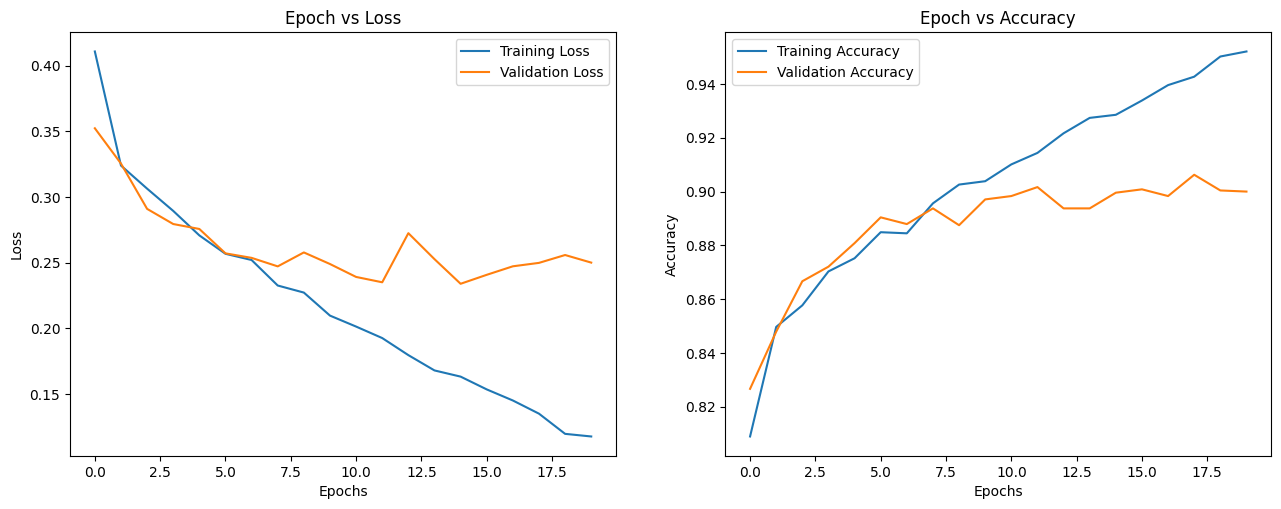

In [13]:
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed
SEED = 1404

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def verify_dataset_files(folder):
    """
    Check if required Fashion-MNIST files exist.
    """
    required_files = [
        "train-images-idx3-ubyte",
        "train-labels-idx1-ubyte",
        "t10k-images-idx3-ubyte",
        "t10k-labels-idx1-ubyte"
    ]
    for file in required_files:
        path = os.path.join(folder, file)
        if not os.path.exists(path):
            print(f"Missing: {path}")
            return False
    return True

def reduce_classes(data):
    """
    Reduce Fashion-MNIST data to two categories: T-Shirts (0) and Shirts (6).
    """
    idx = (data.targets == 0) | (data.targets == 6)
    indices = torch.where(idx)[0]
    data = torch.utils.data.Subset(data, indices)
    mapped_targets = data.dataset.targets[indices].clone()
    mapped_targets[mapped_targets == 6] = 1
    data.dataset.targets[indices] = mapped_targets
    return data

def get_fashion_mnist_dataset(binary=False, download=True, seed=0):
    """
    Get Fashion-MNIST dataset with train, validation, and test splits.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    set_seed(seed)
    
    dataset_root = './FashionMNIST'
    raw_folder = os.path.join(dataset_root, 'raw')
    if not verify_dataset_files(raw_folder):
        print("Dataset files missing. Forcing download...")
        if os.path.exists(dataset_root):
            shutil.rmtree(dataset_root)
        os.makedirs(raw_folder, exist_ok=True)
    
    try:
        train_data = datasets.FashionMNIST(
            root=dataset_root,
            train=True,
            download=download,
            transform=transform
        )
        test_data = datasets.FashionMNIST(
            root=dataset_root,
            train=False,
            download=download,
            transform=transform
        )
    except RuntimeError as e:
        print(f"Dataset loading failed: {e}")
        raise

    print("Dataset loaded successfully!")
    if binary:
        train_data = reduce_classes(train_data)
        test_data = reduce_classes(test_data)
    
    # Split training data into train and validation (80/20)
    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    train_data, validation_data = random_split(train_data, [train_size, val_size])
    
    return train_data, validation_data, test_data

class FMNIST_Net2(nn.Module):
    def __init__(self, num_classes):
        """
        Initialise parameters of FMNIST_Net2.
        """
        super(FMNIST_Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # Add dropout layers
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        """
        Forward pass of FMNIST_Net2.
        """
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)  # Dropout after max-pooling
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)  # Dropout after fc1 ReLU
        x = self.fc2(x)
        return x

def train(model, device, train_loader, validation_loader, epochs):
    """
    Train the model with the specified parameters.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            running_loss = 0.
            correct, total = 0, 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                optimizer.zero_grad()
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            train_loss.append(running_loss / len(train_loader))
            train_acc.append(correct / total)

            model.eval()
            running_loss = 0.
            correct, total = 0, 0
            with torch.no_grad():
                for data, target in validation_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    tepochs.set_postfix(loss=loss.item())
                    running_loss += loss.item()
                    _, predicted = torch.max(output, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
            validation_loss.append(running_loss / len(validation_loader))
            validation_acc.append(correct / total)

    return train_loss, train_acc, validation_loss, validation_acc

def test(model, device, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    """
    Code to plot loss and accuracy.
    """
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

if __name__ == '__main__':
    # Setup
    set_seed(SEED)
    DEVICE = torch.device
    #DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # Get dataset
    num_classes = 2
    train_data, validation_data, test_data = get_fashion_mnist_dataset(binary=True, download=True, seed=SEED)

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
    validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)

    # Verify dataset
    print(f"Train size: {len(train_data)}")
    print(f"Validation size: {len(validation_data)}")
    print(f"Test size: {len(test_data)}")

    # Initialize and train model
    net2 = FMNIST_Net2(num_classes=num_classes).to(DEVICE)
    train_loss, train_acc, validation_loss, validation_acc = train(net2, DEVICE, train_loader, validation_loader, 20)
    print(f'Test accuracy is: {test(net2, DEVICE, test_loader):.4f}')
    plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

**Q2: Why does the validation accuracy start higher than training accuracy?**

`answer:`

Validation accuracy often starts higher than training accuracy because, in the beginning, the model hasn't fully learned to fit the training data yet and is more generalized. Early in training, the model performs better on validation data since validation consists of unseen samples, and the model hasn't started overfitting to the specifics of the training set. Additionally, the training accuracy starts lower as the model weights and biases undergo numerous adjustments during the optimization process, whereas the validation accuracy reflects the model's initial ability to generalize well. As training progresses, the model typically learns to improve both metrics.

Using device: cuda
Dataset loaded successfully!
Train size: 9600
Validation size: 2400
Test size: 2000


Training: 100%|██████████| 20/20 [02:43<00:00,  8.20s/epoch, loss=0.371] 


Test accuracy is: 0.8865


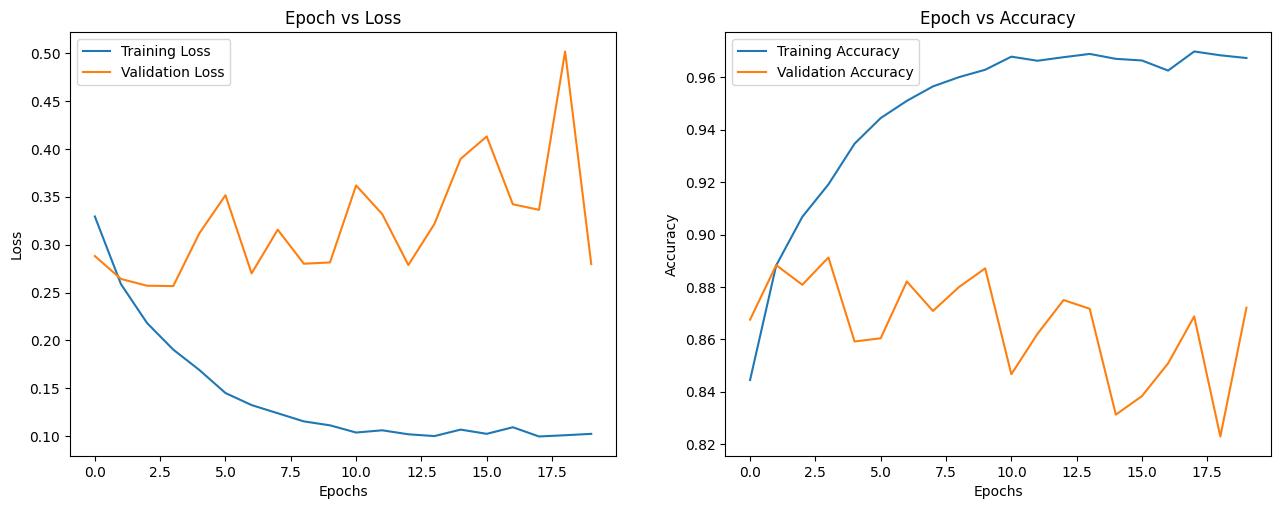

In [31]:
# Define a CNN instance similar to the one above and add different regularization methods to it
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed
SEED = 1404

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def verify_dataset_files(folder):
    required_files = [
        "train-images-idx3-ubyte",
        "train-labels-idx1-ubyte",
        "t10k-images-idx3-ubyte",
        "t10k-labels-idx1-ubyte"
    ]
    for file in required_files:
        path = os.path.join(folder, file)
        if not os.path.exists(path):
            print(f"Missing: {path}")
            return False
    return True

def reduce_classes(data):
    idx = (data.targets == 0) | (data.targets == 6)
    indices = torch.where(idx)[0]
    data = torch.utils.data.Subset(data, indices)
    mapped_targets = data.dataset.targets[indices].clone()
    mapped_targets[mapped_targets == 6] = 1
    data.dataset.targets[indices] = mapped_targets
    return data

def get_fashion_mnist_dataset(binary=False, download=True, seed=0):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    set_seed(seed)
    
    dataset_root = './FashionMNIST'
    raw_folder = os.path.join(dataset_root, 'raw')
    if not verify_dataset_files(raw_folder):
        print("Dataset files missing. Forcing download...")
        if os.path.exists(dataset_root):
            shutil.rmtree(dataset_root)
        os.makedirs(raw_folder, exist_ok=True)
    
    try:
        train_data = datasets.FashionMNIST(
            root=dataset_root,
            train=True,
            download=download,
            transform=transform
        )
        test_data = datasets.FashionMNIST(
            root=dataset_root,
            train=False,
            download=download,
            transform=transform
        )
    except RuntimeError as e:
        print(f"Dataset loading failed: {e}")
        raise

    print("Dataset loaded successfully!")
    if binary:
        train_data = reduce_classes(train_data)
        test_data = reduce_classes(test_data)
    
    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    train_data, validation_data = random_split(train_data, [train_size, val_size])
    
    return train_data, validation_data, test_data

class FMNIST_Net3(nn.Module):
    def __init__(self, num_classes):
        """
        Initialise parameters of FMNIST_Net3 with batch normalization.
        """
        super(FMNIST_Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch norm after conv1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch norm after conv2
        self.fc1 = nn.Linear(9216, 128)
        self.bn3 = nn.BatchNorm1d(128)  # Batch norm after fc1
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        """
        Forward pass of FMNIST_Net3.
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

def train(model, device, train_loader, validation_loader, epochs):
    """
    Train the model with L2 regularization (weight decay).
    """
    criterion = nn.CrossEntropyLoss()
    # Add L2 regularization via weight decay
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            running_loss = 0.
            correct, total = 0, 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                optimizer.zero_grad()
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            train_loss.append(running_loss / len(train_loader))
            train_acc.append(correct / total)

            model.eval()
            running_loss = 0.
            correct, total = 0, 0
            with torch.no_grad():
                for data, target in validation_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    tepochs.set_postfix(loss=loss.item())
                    running_loss += loss.item()
                    _, predicted = torch.max(output, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
            validation_loss.append(running_loss / len(validation_loader))
            validation_acc.append(correct / total)

    return train_loss, train_acc, validation_loss, validation_acc

def test(model, device, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    """
    Code to plot loss and accuracy.
    """
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

if __name__ == '__main__':
    # Setup
    set_seed(SEED)
    DEVICE = torch.device
    #DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # Get dataset
    num_classes = 2
    train_data, validation_data, test_data = get_fashion_mnist_dataset(binary=True, download=True, seed=SEED)

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
    validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)

    # Verify dataset
    print(f"Train size: {len(train_data)}")
    print(f"Validation size: {len(validation_data)}")
    print(f"Test size: {len(test_data)}")

    # Initialize and train model
    net3 = FMNIST_Net3(num_classes=num_classes).to(DEVICE)
    train_loss, train_acc, validation_loss, validation_acc = train(net3, DEVICE, train_loader, validation_loader, 20)
    print(f'Test accuracy is: {test(net3, DEVICE, test_loader):.4f}')
    plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)
# YOUR CODE

## Data Augmentation

Now, Let's add data augmentation to the model via transforms and see if that helps it generalize better.

* Add the transforms you want in the list `augmentation_transforms`.

* Run the same network you created in the above exercise (with regularization) and plot the loss and accuracies.



> [Here](https://pytorch.org/vision/stable/transforms.html) is the link to the list of transforms available in PyTorch.



Using device: cuda
Dataset loaded successfully!
Train batches: 150
Validation batches: 38
Test batches: 32


Training: 100%|██████████| 20/20 [03:53<00:00, 11.67s/epoch, loss=0.225]


Test accuracy is: 0.8810


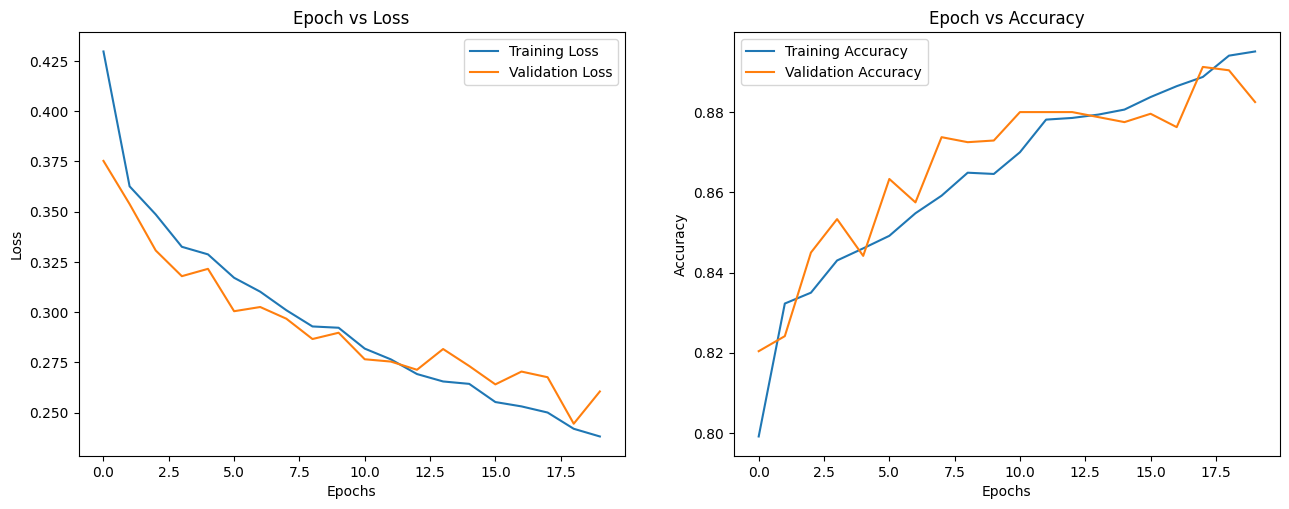

In [33]:
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed
SEED = 1404

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def verify_dataset_files(folder):
    required_files = [
        "train-images-idx3-ubyte",
        "train-labels-idx1-ubyte",
        "t10k-images-idx3-ubyte",
        "t10k-labels-idx1-ubyte"
    ]
    for file in required_files:
        path = os.path.join(folder, file)
        if not os.path.exists(path):
            print(f"Missing: {path}")
            return False
    return True

def reduce_classes(data):
    idx = (data.targets == 0) | (data.targets == 6)
    indices = torch.where(idx)[0]
    data = torch.utils.data.Subset(data, indices)
    mapped_targets = data.dataset.targets[indices].clone()
    mapped_targets[mapped_targets == 6] = 1
    data.dataset.targets[indices] = mapped_targets
    return data

def get_augmentation_transforms():
    """
    Returns Augmentation Transforms.
    """
    augmentation_transforms = [
        transforms.RandomRotation(degrees=10),  # Rotate by ±10 degrees
        transforms.RandomHorizontalFlip(p=0.5)  # 50% chance of horizontal flip
    ]
    return augmentation_transforms

def get_data_loaders(train_data, validation_data, test_data, seed):
    """
    Create DataLoaders for train, validation, and test sets.
    """
    set_seed(seed)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
    validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)
    return train_loader, validation_loader, test_loader

def transforms_custom(binary=False, download=True, seed=0):
    """
    Helper function defining transformations and returning DataLoaders.
    """
    # Basic preprocessing
    preprocessing_transforms = [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
    # Augmentation for training only
    train_transform = transforms.Compose(get_augmentation_transforms() + preprocessing_transforms)
    # Test/validation use preprocessing only
    test_transform = transforms.Compose(preprocessing_transforms)

    # Verify dataset directory
    dataset_root = './FashionMNIST'
    raw_folder = os.path.join(dataset_root, 'raw')
    if not verify_dataset_files(raw_folder):
        print("Dataset files missing. Forcing download...")
        if os.path.exists(dataset_root):
            shutil.rmtree(dataset_root)
        os.makedirs(raw_folder, exist_ok=True)

    # Load datasets
    try:
        train_data = datasets.FashionMNIST(
            root=dataset_root,
            train=True,
            download=download,
            transform=train_transform
        )
        test_data = datasets.FashionMNIST(
            root=dataset_root,
            train=False,
            download=download,
            transform=test_transform
        )
    except RuntimeError as e:
        print(f"Dataset loading failed: {e}")
        raise

    print("Dataset loaded successfully!")
    if binary:
        train_data = reduce_classes(train_data)
        test_data = reduce_classes(test_data)

    # Split train into train/validation (80/20)
    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    train_data, validation_data = random_split(train_data, [train_size, val_size])

    # Get DataLoaders
    train_loader, validation_loader, test_loader = get_data_loaders(
        train_data, validation_data, test_data, seed
    )
    return train_loader, validation_loader, test_loader

class FMNIST_Net2(nn.Module):
    def __init__(self, num_classes):
        super(FMNIST_Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

def train(model, device, train_loader, validation_loader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            running_loss = 0.
            correct, total = 0, 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                optimizer.zero_grad()
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            train_loss.append(running_loss / len(train_loader))
            train_acc.append(correct / total)

            model.eval()
            running_loss = 0.
            correct, total = 0, 0
            with torch.no_grad():
                for data, target in validation_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    tepochs.set_postfix(loss=loss.item())
                    running_loss += loss.item()
                    _, predicted = torch.max(output, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
            validation_loss.append(running_loss / len(validation_loader))
            validation_acc.append(correct / total)

    return train_loss, train_acc, validation_loss, validation_acc

def test(model, device, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

if __name__ == '__main__':
    # Setup
    set_seed(SEED)
    DEVICE = torch.device#("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # Get DataLoaders with augmentations
    train_loader, validation_loader, test_loader = transforms_custom(binary=True, seed=SEED)

    # Verify dataset
    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(validation_loader)}")
    print(f"Test batches: {len(test_loader)}")

    # Initialize and train model
    net3 = FMNIST_Net2(num_classes=2).to(DEVICE)  # Note: Using FMNIST_Net2 as per your code
    train_loss, train_acc, validation_loss, validation_acc = train(net3, DEVICE, train_loader, validation_loader, 20)
    print(f'Test accuracy is: {test(net3, DEVICE, test_loader):.4f}')
    plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

**Q3: Did the training accuracy reduce further compared to dropout alone? Is the model still overfitting?**

`answer:`

Regarding overfitting, the model does not seem to suffer from it significantly. The training and validation accuracy curves are close to each other, demonstrating good generalization. However, towards the end, there is a slight dip in validation accuracy, which might hint at minor overfitting. This could be addressed by further refining regularization techniques, such as increasing dropout probability or incorporating other methods like data augmentation or early stopping.

# Further Tasks

## Task 1: BatchNorm Experiment

Replace the dropout layers with `BatchNorm2d` layers. Compare performance, overfitting behavior, and convergence speed.

**Q: which should be applied first if implementing both in a CNN? why?**



`answer:`

When implementing both dropout and batch normalization (BatchNorm2d) in a CNN, BatchNorm should generally be applied before Dropout. Here's why:

Normalization Impact: Batch normalization standardizes the activations within a layer, ensuring that the input distribution to the next layer remains consistent during training. This helps stabilize and accelerate convergence.

Dropout Behavior: Dropout randomly deactivates neurons during training. Applying it after BatchNorm ensures that the activations have already been normalized, preventing dropout from interfering with the normalization process.

Order Logic: If dropout were applied first, the random deactivation could disrupt the statistical properties of the data, making batch normalization less effective. BatchNorm works best with the complete set of activations.

In short, BatchNorm helps provide consistency and reduces internal covariate shift, while Dropout encourages generalization. Applying BatchNorm first ensures the CNN benefits fully from these complementary techniques.

Using device: cuda
Dataset loaded successfully!
Train batches: 150
Validation batches: 38
Test batches: 32


Training FMNIST_Net2: 100%|██████████| 20/20 [02:40<00:00,  8.05s/epoch, train_loss=0.238, val_loss=0.261]


FMNIST_Net2 (Dropout) Test accuracy: 0.8810


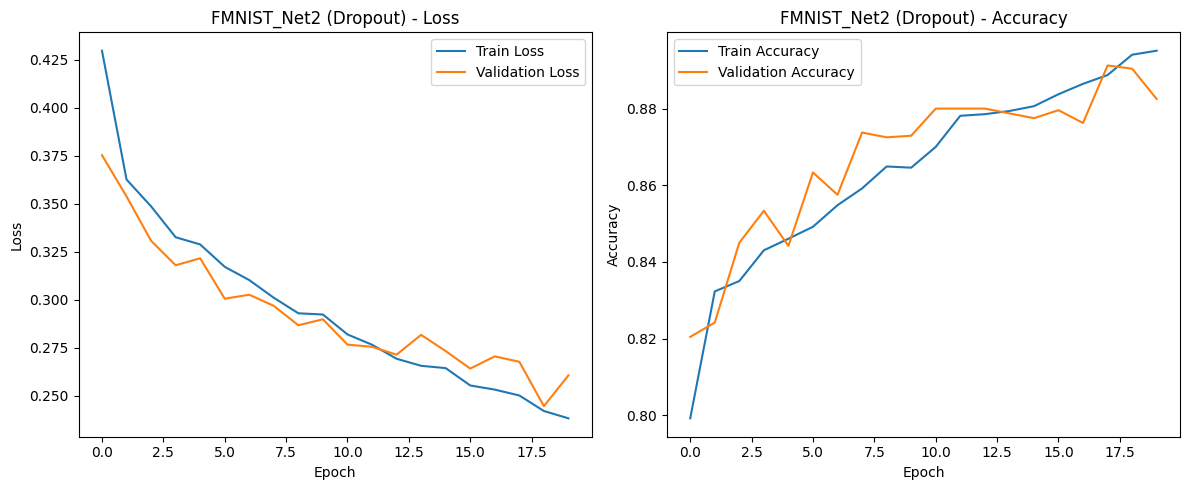

Training FMNIST_Net_BN: 100%|██████████| 20/20 [04:21<00:00, 13.05s/epoch, train_loss=0.114, val_loss=0.384]


FMNIST_Net_BN (BatchNorm) Test accuracy: 0.8755


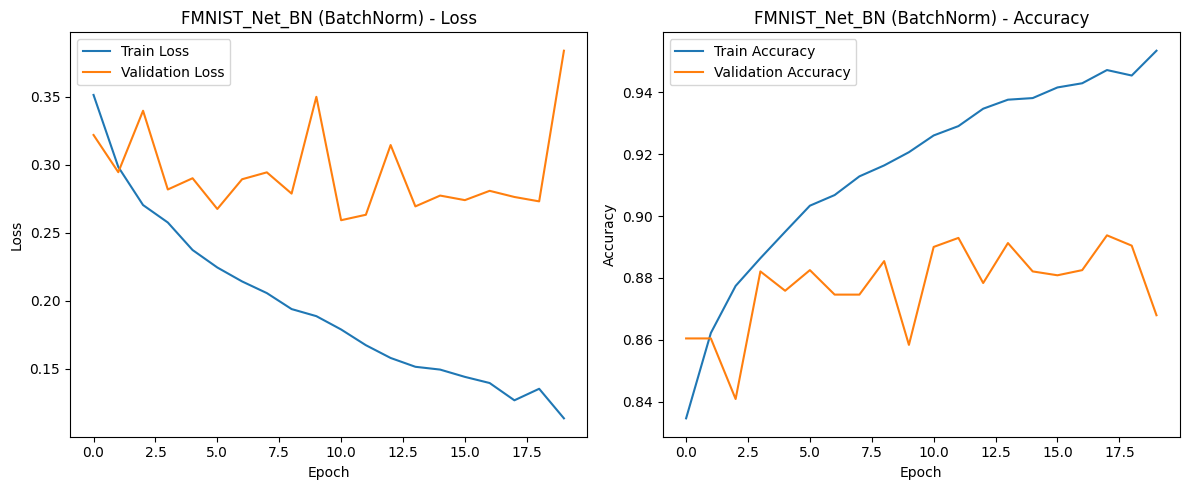


Comparison Analysis:
FMNIST_Net2 - Final Train Acc: 0.8951, Val Acc: 0.8825, Overfitting Gap: 0.0126
FMNIST_Net_BN - Final Train Acc: 0.9534, Val Acc: 0.8679, Overfitting Gap: 0.0855


In [36]:
# YOUR CODE HERE
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed
SEED = 1404

def plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, title="Model Performance"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def verify_dataset_files(folder):
    required_files = [
        "train-images-idx3-ubyte",
        "train-labels-idx1-ubyte",
        "t10k-images-idx3-ubyte",
        "t10k-labels-idx1-ubyte"
    ]
    for file in required_files:
        path = os.path.join(folder, file)
        if not os.path.exists(path):
            print(f"Missing: {path}")
            return False
    return True

def reduce_classes(data):
    idx = (data.targets == 0) | (data.targets == 6)
    indices = torch.where(idx)[0]
    data = torch.utils.data.Subset(data, indices)
    mapped_targets = data.dataset.targets[indices].clone()
    mapped_targets[mapped_targets == 6] = 1
    data.dataset.targets[indices] = mapped_targets
    return data

def get_augmentation_transforms():
    """
    Returns Augmentation Transforms.
    """
    return [
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(p=0.5)
    ]

def get_data_loaders(train_data, validation_data, test_data, seed):
    set_seed(seed)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
    validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)
    return train_loader, validation_loader, test_loader

def transforms_custom(binary=False, download=True, seed=0):
    """
    Helper function defining transformations and returning DataLoaders.
    """
    preprocessing_transforms = [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
    train_transform = transforms.Compose(get_augmentation_transforms() + preprocessing_transforms)
    test_transform = transforms.Compose(preprocessing_transforms)

    dataset_root = './FashionMNIST'
    raw_folder = os.path.join(dataset_root, 'raw')
    if not verify_dataset_files(raw_folder):
        print("Dataset files missing. Forcing download...")
        if os.path.exists(dataset_root):
            shutil.rmtree(dataset_root)
        os.makedirs(raw_folder, exist_ok=True)

    try:
        train_data = datasets.FashionMNIST(
            root=dataset_root,
            train=True,
            download=download,
            transform=train_transform
        )
        test_data = datasets.FashionMNIST(
            root=dataset_root,
            train=False,
            download=download,
            transform=test_transform
        )
    except RuntimeError as e:
        print(f"Dataset loading failed: {e}")
        raise

    print("Dataset loaded successfully!")
    if binary:
        train_data = reduce_classes(train_data)
        test_data = reduce_classes(test_data)

    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    train_data, validation_data = random_split(train_data, [train_size, val_size])

    return get_data_loaders(train_data, validation_data, test_data, seed)

# New model with batch normalization
class FMNIST_Net_BN(nn.Module):
    def __init__(self, num_classes):
        super(FMNIST_Net_BN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm after conv1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm after conv2
        self.fc1 = nn.Linear(9216, 128)
        self.bn3 = nn.BatchNorm1d(128)  # BatchNorm after fc1 (1D for dense layer)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

def train(model, device, train_loader, validation_loader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description(f'Training {model.__class__.__name__}')
        for epoch in tepochs:
            model.train()
            running_loss = 0.
            correct, total = 0, 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                optimizer.zero_grad()
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            train_loss.append(running_loss / len(train_loader))
            train_acc.append(correct / total)

            model.eval()
            running_loss = 0.
            correct, total = 0, 0
            with torch.no_grad():
                for data, target in validation_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    running_loss += loss.item()
                    _, predicted = torch.max(output, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
            validation_loss.append(running_loss / len(validation_loader))
            validation_acc.append(correct / total)
            tepochs.set_postfix(train_loss=train_loss[-1], val_loss=validation_loss[-1])

    return train_loss, train_acc, validation_loss, validation_acc


if __name__ == '__main__':
    # Setup
    set_seed(SEED)
    DEVICE = torch.device#("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # Get DataLoaders
    train_loader, validation_loader, test_loader = transforms_custom(binary=True, seed=SEED)
    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(validation_loader)}")
    print(f"Test batches: {len(test_loader)}")

    # Train FMNIST_Net2 (Dropout)
    net2 = FMNIST_Net2(num_classes=2).to(DEVICE)
    train_loss2, train_acc2, val_loss2, val_acc2 = train(net2, DEVICE, train_loader, validation_loader, 20)
    test_acc2 = test(net2, DEVICE, test_loader)
    print(f'FMNIST_Net2 (Dropout) Test accuracy: {test_acc2:.4f}')
    plot_loss_accuracy(train_loss2, train_acc2, val_loss2, val_acc2, "FMNIST_Net2 (Dropout)")

    # Train FMNIST_Net_BN (BatchNorm)
    net_bn = FMNIST_Net_BN(num_classes=2).to(DEVICE)
    train_loss_bn, train_acc_bn, val_loss_bn, val_acc_bn = train(net_bn, DEVICE, train_loader, validation_loader, 20)
    test_acc_bn = test(net_bn, DEVICE, test_loader)
    print(f'FMNIST_Net_BN (BatchNorm) Test accuracy: {test_acc_bn:.4f}')
    plot_loss_accuracy(train_loss_bn, train_acc_bn, val_loss_bn, val_acc_bn, "FMNIST_Net_BN (BatchNorm)")

    # Comparison Analysis
    print("\nComparison Analysis:")
    print(f"FMNIST_Net2 - Final Train Acc: {train_acc2[-1]:.4f}, Val Acc: {val_acc2[-1]:.4f}, Overfitting Gap: {train_acc2[-1] - val_acc2[-1]:.4f}")
    print(f"FMNIST_Net_BN - Final Train Acc: {train_acc_bn[-1]:.4f}, Val Acc: {val_acc_bn[-1]:.4f}, Overfitting Gap: {train_acc_bn[-1] - val_acc_bn[-1]:.4f}")

## Task 2: Early Stopping

Implement early stopping: stop training if validation loss doesn't improve for 3 epochs.

**Q: How does this help preventing overfitting and saving computational cost?**

`answer:`

Early stopping helps mitigate overfitting by halting the training process once validation loss stops improving for a defined number of epochs (e.g., 3 in your case). By monitoring validation loss, early stopping prevents the model from overtraining on the training data, which could lead to poorer generalization to unseen data. At the same time, it saves computational cost by eliminating unnecessary epochs where no significant improvement occurs, reducing wasted processing time and energy. This efficient approach balances model performance and resource utilization, ensuring both better generalization and a streamlined training process.

Using device: cuda
Dataset loaded successfully!
Train batches: 150
Validation batches: 38
Test batches: 32


Training FMNIST_Net2:  75%|███████▌  | 15/20 [02:17<00:45,  9.15s/epoch, train_loss=0.273, val_loss=0.287]



Early stopping triggered after 16 epochs.
FMNIST_Net2 (Dropout) Test accuracy: 0.8635


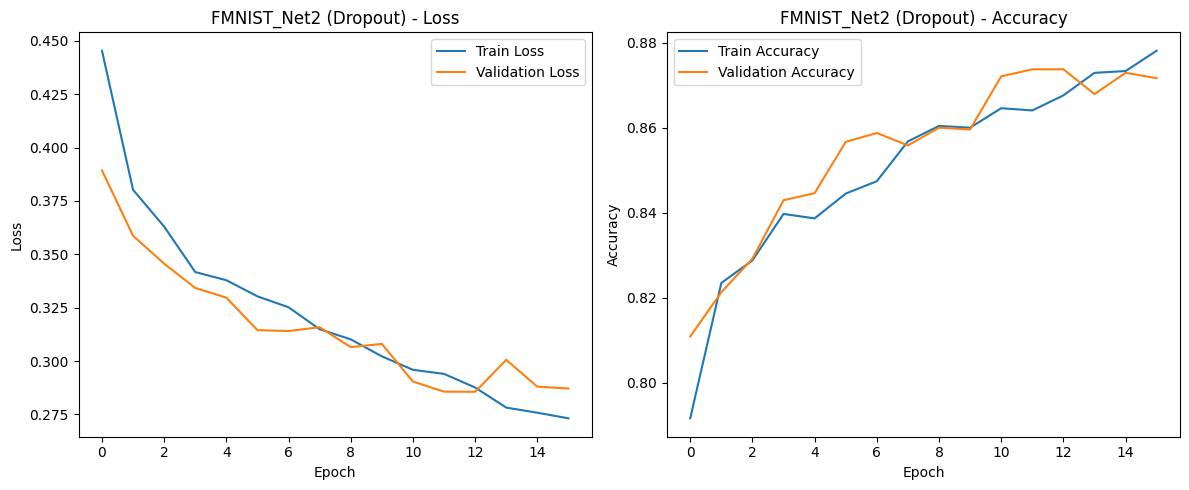

Training FMNIST_Net_BN:  30%|███       | 6/20 [01:46<04:08, 17.77s/epoch, train_loss=0.212, val_loss=0.362]



Early stopping triggered after 7 epochs.
FMNIST_Net_BN (BatchNorm) Test accuracy: 0.8455


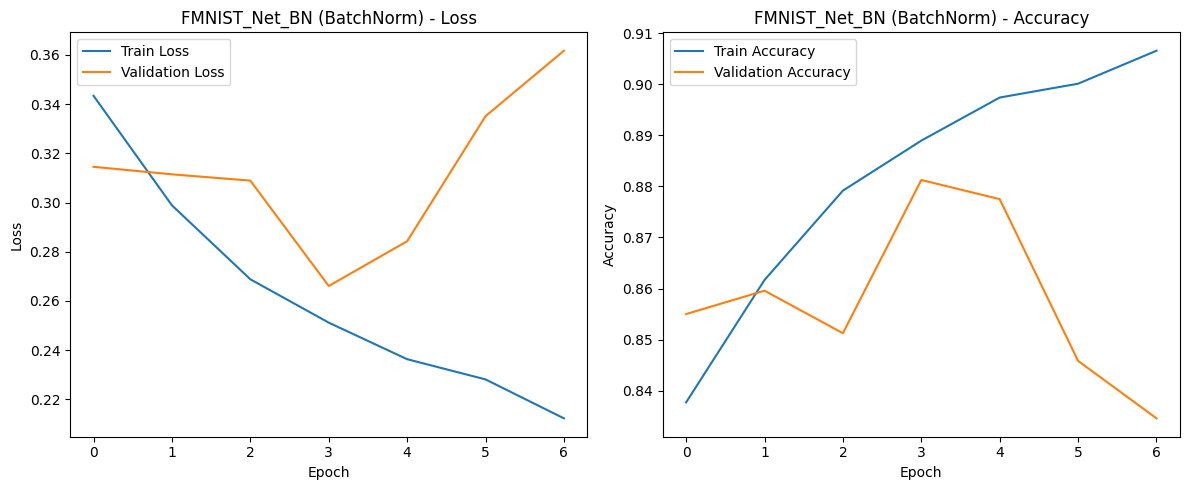


Comparison Analysis:
FMNIST_Net2 - Final Train Acc: 0.8781, Val Acc: 0.8717, Overfitting Gap: 0.0065
FMNIST_Net_BN - Final Train Acc: 0.9066, Val Acc: 0.8346, Overfitting Gap: 0.0720


In [38]:
def plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, title="Model Performance"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


def test(model, device, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total


def train(model, device, train_loader, validation_loader, epochs, patience=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description(f'Training {model.__class__.__name__}')
        for epoch in tepochs:
            model.train()
            running_loss = 0.
            correct, total = 0, 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                optimizer.zero_grad()
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            train_loss.append(running_loss / len(train_loader))
            train_acc.append(correct / total)

            # Validation
            model.eval()
            running_loss = 0.
            correct, total = 0, 0
            with torch.no_grad():
                for data, target in validation_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    running_loss += loss.item()
                    _, predicted = torch.max(output, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
            val_loss = running_loss / len(validation_loader)
            val_acc = correct / total
            validation_loss.append(val_loss)
            validation_acc.append(val_acc)

            tepochs.set_postfix(train_loss=train_loss[-1], val_loss=val_loss)

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"\nEarly stopping triggered after {epoch+1} epochs.")
                    break

    return train_loss, train_acc, validation_loss, validation_acc


# Dummy dropout model (must exist or be implemented)
class FMNIST_Net2(nn.Module):
    def __init__(self, num_classes):
        super(FMNIST_Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x


# ===== MAIN BLOCK =====
if __name__ == '__main__':
    # Setup
    set_seed(SEED)
    DEVICE = torch.device#("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # Load data
    train_loader, validation_loader, test_loader = transforms_custom(binary=True, seed=SEED)
    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(validation_loader)}")
    print(f"Test batches: {len(test_loader)}")

    # --- Train Dropout Model ---
    net2 = FMNIST_Net2(num_classes=2).to(DEVICE)
    train_loss2, train_acc2, val_loss2, val_acc2 = train(net2, DEVICE, train_loader, validation_loader, epochs=20, patience=3)
    test_acc2 = test(net2, DEVICE, test_loader)
    print(f'FMNIST_Net2 (Dropout) Test accuracy: {test_acc2:.4f}')
    plot_loss_accuracy(train_loss2, train_acc2, val_loss2, val_acc2, "FMNIST_Net2 (Dropout)")

    # --- Train BatchNorm Model ---
    net_bn = FMNIST_Net_BN(num_classes=2).to(DEVICE)
    train_loss_bn, train_acc_bn, val_loss_bn, val_acc_bn = train(net_bn, DEVICE, train_loader, validation_loader, epochs=20, patience=3)
    test_acc_bn = test(net_bn, DEVICE, test_loader)
    print(f'FMNIST_Net_BN (BatchNorm) Test accuracy: {test_acc_bn:.4f}')
    plot_loss_accuracy(train_loss_bn, train_acc_bn, val_loss_bn, val_acc_bn, "FMNIST_Net_BN (BatchNorm)")

    # --- Comparison ---
    print("\nComparison Analysis:")
    print(f"FMNIST_Net2 - Final Train Acc: {train_acc2[-1]:.4f}, Val Acc: {val_acc2[-1]:.4f}, Overfitting Gap: {train_acc2[-1] - val_acc2[-1]:.4f}")
    print(f"FMNIST_Net_BN - Final Train Acc: {train_acc_bn[-1]:.4f}, Val Acc: {val_acc_bn[-1]:.4f}, Overfitting Gap: {train_acc_bn[-1] - val_acc_bn[-1]:.4f}")


## Task 3: Try New Augmentations

Experiment with different augmentation strategies. How do they impact training?”

`answer:`
The augmentation strategy enhances generalization and robustness. Transforms like `RandomCrop`, `RandomHorizontalFlip`, and `RandomRotation` introduce variability, preventing overfitting and improving performance on unseen data. Meanwhile, techniques like `ColorJitter` and `GaussianBlur` simulate real-world scenarios, equipping your model to handle diverse conditions effectively.

However, overuse of augmentations may backfire by introducing unrealistic distortions that hinder training. To assess their impact, compare a baseline model against those trained with various augmentation combinations, tracking validation loss and accuracy. This approach ensures a balance between augmented diversity and realistic data representation. Let me know if you'd like help tweaking this further!

Using device: cuda
Dataset loaded successfully!
Train batches: 150
Validation batches: 38
Test batches: 32


Training FMNIST_Net2: 100%|██████████| 20/20 [11:46<00:00, 35.31s/epoch, train_loss=0.369, val_loss=0.353]


FMNIST_Net2 (Dropout) Test accuracy: 0.8310


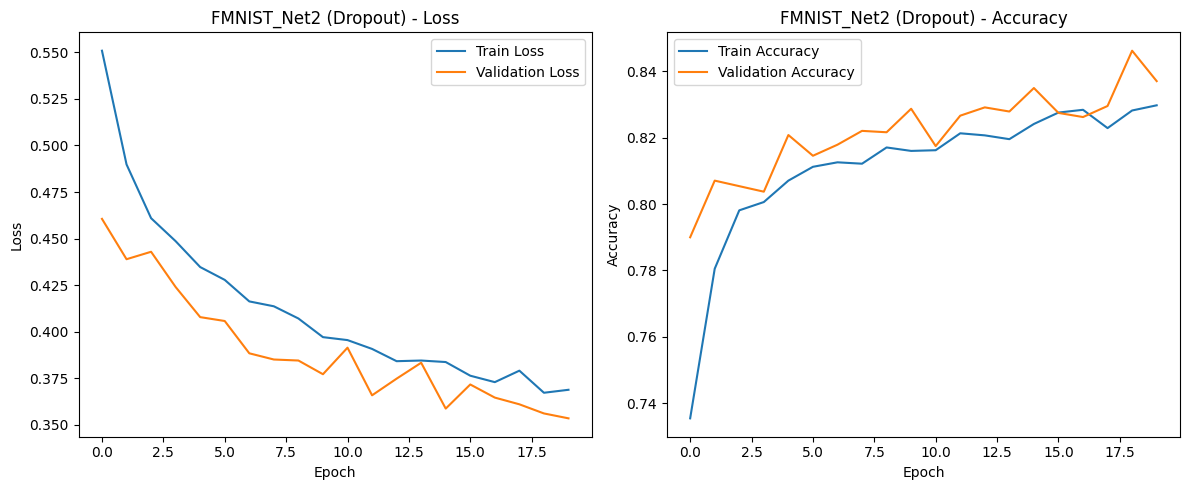

Training FMNIST_Net_BN:  40%|████      | 8/20 [03:30<05:16, 26.34s/epoch, train_loss=0.37, val_loss=0.361] 


KeyboardInterrupt: 

In [14]:
# YOUR CODE HERE
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed
SEED = 1404

def plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, title="Model Performance"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def verify_dataset_files(folder):
    required_files = [
        "train-images-idx3-ubyte",
        "train-labels-idx1-ubyte",
        "t10k-images-idx3-ubyte",
        "t10k-labels-idx1-ubyte"
    ]
    for file in required_files:
        path = os.path.join(folder, file)
        if not os.path.exists(path):
            print(f"Missing: {path}")
            return False
    return True

def reduce_classes(data):
    idx = (data.targets == 0) | (data.targets == 6)
    indices = torch.where(idx)[0]
    data = torch.utils.data.Subset(data, indices)
    mapped_targets = data.dataset.targets[indices].clone()
    mapped_targets[mapped_targets == 6] = 1
    data.dataset.targets[indices] = mapped_targets
    return data

def get_augmentation_transforms():
    """
    Returns enhanced Augmentation Transforms.
    """
    return [
        transforms.RandomCrop(28, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.GaussianBlur(kernel_size=(3, 3))
    ]


def get_data_loaders(train_data, validation_data, test_data, seed):
    set_seed(seed)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
    validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)
    return train_loader, validation_loader, test_loader

def transforms_custom(binary=False, download=True, seed=0):
    """
    Helper function defining transformations and returning DataLoaders.
    """
    preprocessing_transforms = [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
    train_transform = transforms.Compose(get_augmentation_transforms() + preprocessing_transforms)
    test_transform = transforms.Compose(preprocessing_transforms)

    dataset_root = './FashionMNIST'
    raw_folder = os.path.join(dataset_root, 'raw')
    if not verify_dataset_files(raw_folder):
        print("Dataset files missing. Forcing download...")
        if os.path.exists(dataset_root):
            shutil.rmtree(dataset_root)
        os.makedirs(raw_folder, exist_ok=True)

    try:
        train_data = datasets.FashionMNIST(
            root=dataset_root,
            train=True,
            download=download,
            transform=train_transform
        )
        test_data = datasets.FashionMNIST(
            root=dataset_root,
            train=False,
            download=download,
            transform=test_transform
        )
    except RuntimeError as e:
        print(f"Dataset loading failed: {e}")
        raise

    print("Dataset loaded successfully!")
    if binary:
        train_data = reduce_classes(train_data)
        test_data = reduce_classes(test_data)

    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    train_data, validation_data = random_split(train_data, [train_size, val_size])

    return get_data_loaders(train_data, validation_data, test_data, seed)

# New model with batch normalization
class FMNIST_Net_BN(nn.Module):
    def __init__(self, num_classes):
        super(FMNIST_Net_BN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm after conv1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm after conv2
        self.fc1 = nn.Linear(9216, 128)
        self.bn3 = nn.BatchNorm1d(128)  # BatchNorm after fc1 (1D for dense layer)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

def train(model, device, train_loader, validation_loader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description(f'Training {model.__class__.__name__}')
        for epoch in tepochs:
            model.train()
            running_loss = 0.
            correct, total = 0, 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                optimizer.zero_grad()
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            train_loss.append(running_loss / len(train_loader))
            train_acc.append(correct / total)

            model.eval()
            running_loss = 0.
            correct, total = 0, 0
            with torch.no_grad():
                for data, target in validation_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    running_loss += loss.item()
                    _, predicted = torch.max(output, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
            validation_loss.append(running_loss / len(validation_loader))
            validation_acc.append(correct / total)
            tepochs.set_postfix(train_loss=train_loss[-1], val_loss=validation_loss[-1])

    return train_loss, train_acc, validation_loss, validation_acc


if __name__ == '__main__':
    # Setup
    set_seed(SEED)
    DEVICE = torch.device#("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # Get DataLoaders
    train_loader, validation_loader, test_loader = transforms_custom(binary=True, seed=SEED)
    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(validation_loader)}")
    print(f"Test batches: {len(test_loader)}")

    # Train FMNIST_Net2 (Dropout)
    net2 = FMNIST_Net2(num_classes=2).to(DEVICE)
    train_loss2, train_acc2, val_loss2, val_acc2 = train(net2, DEVICE, train_loader, validation_loader, 20)
    test_acc2 = test(net2, DEVICE, test_loader)
    print(f'FMNIST_Net2 (Dropout) Test accuracy: {test_acc2:.4f}')
    plot_loss_accuracy(train_loss2, train_acc2, val_loss2, val_acc2, "FMNIST_Net2 (Dropout)")

    # Train FMNIST_Net_BN (BatchNorm)
    net_bn = FMNIST_Net_BN(num_classes=2).to(DEVICE)
    train_loss_bn, train_acc_bn, val_loss_bn, val_acc_bn = train(net_bn, DEVICE, train_loader, validation_loader, 20)
    test_acc_bn = test(net_bn, DEVICE, test_loader)
    print(f'FMNIST_Net_BN (BatchNorm) Test accuracy: {test_acc_bn:.4f}')
    plot_loss_accuracy(train_loss_bn, train_acc_bn, val_loss_bn, val_acc_bn, "FMNIST_Net_BN (BatchNorm)")

    # Comparison Analysis
    print("\nComparison Analysis:")
    print(f"FMNIST_Net2 - Final Train Acc: {train_acc2[-1]:.4f}, Val Acc: {val_acc2[-1]:.4f}, Overfitting Gap: {train_acc2[-1] - val_acc2[-1]:.4f}")
    print(f"FMNIST_Net_BN - Final Train Acc: {train_acc_bn[-1]:.4f}, Val Acc: {val_acc_bn[-1]:.4f}, Overfitting Gap: {train_acc_bn[-1] - val_acc_bn[-1]:.4f}")

## Task 4: Compare Optimizers

Compare model performance when trained with SGD, Adam, and RMSProp. Plot the loss curves.

Using device: cuda
Dataset loaded successfully!

Training with SGD optimizer...


Training FMNIST_Net_BN with SGD: 100%|██████████| 20/20 [01:59<00:00,  5.95s/epoch, train_loss=0.116, val_loss=0.284]


SGD Test Accuracy: 0.8995

Training with Adam optimizer...


Training FMNIST_Net_BN with Adam: 100%|██████████| 20/20 [01:57<00:00,  5.89s/epoch, train_loss=0.0937, val_loss=0.293]


Adam Test Accuracy: 0.8900

Training with RMSProp optimizer...


Training FMNIST_Net_BN with RMSprop: 100%|██████████| 20/20 [01:58<00:00,  5.94s/epoch, train_loss=0.104, val_loss=0.299]


RMSProp Test Accuracy: 0.8955


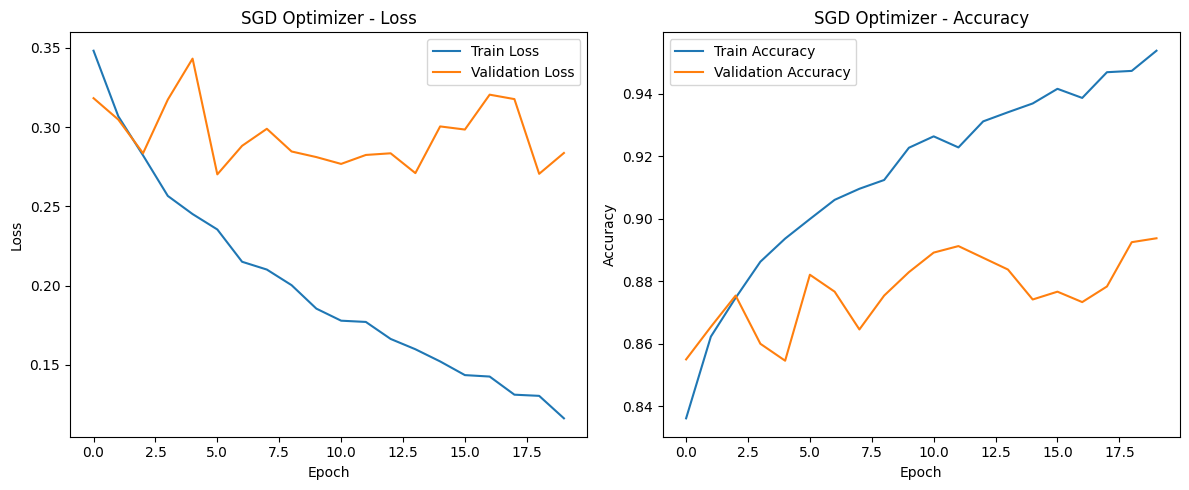

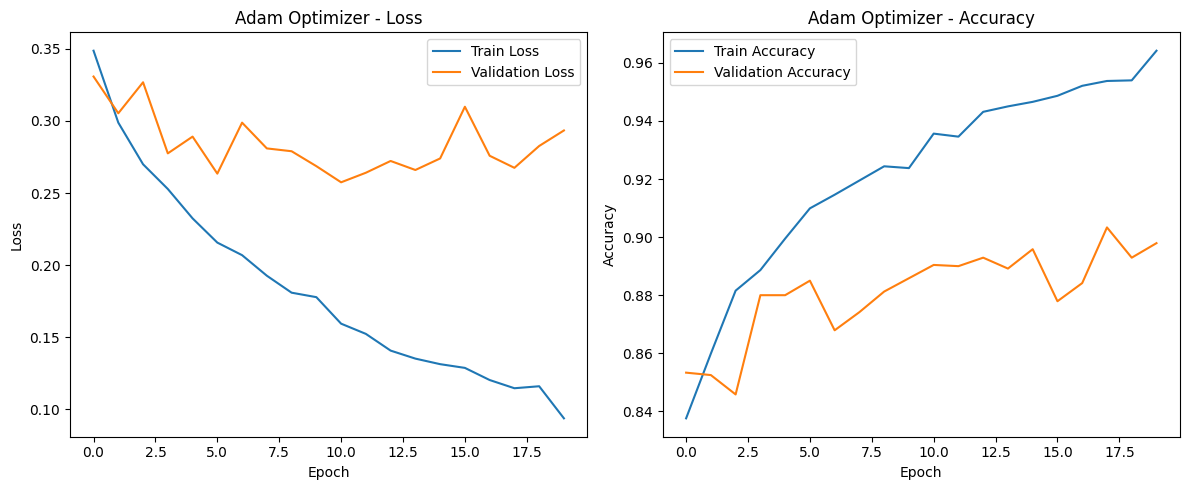

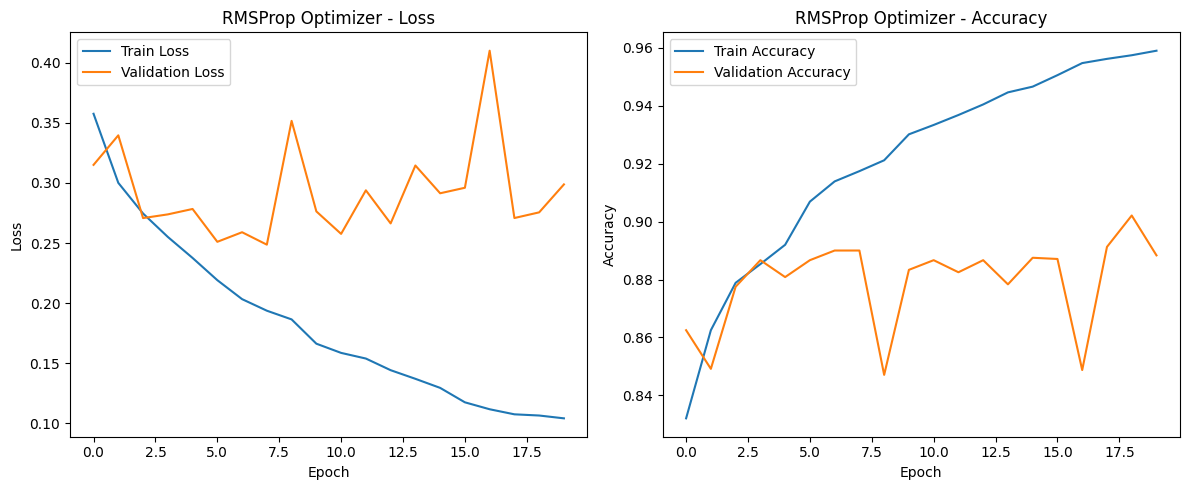

In [16]:
# YOUR CODE HERE
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed
SEED = 1404

def plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, title="Model Performance"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def verify_dataset_files(folder):
    required_files = [
        "train-images-idx3-ubyte",
        "train-labels-idx1-ubyte",
        "t10k-images-idx3-ubyte",
        "t10k-labels-idx1-ubyte"
    ]
    for file in required_files:
        path = os.path.join(folder, file)
        if not os.path.exists(path):
            print(f"Missing: {path}")
            return False
    return True

def reduce_classes(data):
    idx = (data.targets == 0) | (data.targets == 6)
    indices = torch.where(idx)[0]
    data = torch.utils.data.Subset(data, indices)
    mapped_targets = data.dataset.targets[indices].clone()
    mapped_targets[mapped_targets == 6] = 1
    data.dataset.targets[indices] = mapped_targets
    return data

def get_augmentation_transforms():
    """
    Returns Augmentation Transforms.
    """
    return [
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(p=0.5)
    ]

def get_data_loaders(train_data, validation_data, test_data, seed):
    set_seed(seed)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
    validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)
    return train_loader, validation_loader, test_loader

def transforms_custom(binary=False, download=True, seed=0):
    """
    Helper function defining transformations and returning DataLoaders.
    """
    preprocessing_transforms = [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
    train_transform = transforms.Compose(get_augmentation_transforms() + preprocessing_transforms)
    test_transform = transforms.Compose(preprocessing_transforms)

    dataset_root = './FashionMNIST'
    raw_folder = os.path.join(dataset_root, 'raw')
    if not verify_dataset_files(raw_folder):
        print("Dataset files missing. Forcing download...")
        if os.path.exists(dataset_root):
            shutil.rmtree(dataset_root)
        os.makedirs(raw_folder, exist_ok=True)

    try:
        train_data = datasets.FashionMNIST(
            root=dataset_root,
            train=True,
            download=download,
            transform=train_transform
        )
        test_data = datasets.FashionMNIST(
            root=dataset_root,
            train=False,
            download=download,
            transform=test_transform
        )
    except RuntimeError as e:
        print(f"Dataset loading failed: {e}")
        raise

    print("Dataset loaded successfully!")
    if binary:
        train_data = reduce_classes(train_data)
        test_data = reduce_classes(test_data)

    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    train_data, validation_data = random_split(train_data, [train_size, val_size])

    return get_data_loaders(train_data, validation_data, test_data, seed)

# Model with batch normalization
class FMNIST_Net_BN(nn.Module):
    def __init__(self, num_classes):
        super(FMNIST_Net_BN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm after conv1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm after conv2
        self.fc1 = nn.Linear(9216, 128)
        self.bn3 = nn.BatchNorm1d(128)  # BatchNorm after fc1 (1D for dense layer)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

def train_with_optimizer(model, device, train_loader, validation_loader, epochs, optimizer):
    criterion = nn.CrossEntropyLoss()
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description(f'Training {model.__class__.__name__} with {type(optimizer).__name__}')
        for epoch in tepochs:
            model.train()
            running_loss = 0.
            correct, total = 0, 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                optimizer.zero_grad()
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            train_loss.append(running_loss / len(train_loader))
            train_acc.append(correct / total)

            model.eval()
            running_loss = 0.
            correct, total = 0, 0
            with torch.no_grad():
                for data, target in validation_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    running_loss += loss.item()
                    _, predicted = torch.max(output, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
            validation_loss.append(running_loss / len(validation_loader))
            validation_acc.append(correct / total)
            tepochs.set_postfix(train_loss=train_loss[-1], val_loss=validation_loss[-1])

    return train_loss, train_acc, validation_loss, validation_acc

# Comparison of Optimizers
if __name__ == '__main__':
    # Setup
    set_seed(SEED)
    DEVICE = torch.device#("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # Get DataLoaders
    train_loader, validation_loader, test_loader = transforms_custom(binary=True, seed=SEED)

    optimizers = {
        "SGD": optim.SGD,
        "Adam": optim.Adam,
        "RMSProp": optim.RMSprop
    }

    results = {}
    for opt_name, opt_class in optimizers.items():
        print(f"\nTraining with {opt_name} optimizer...")
        model = FMNIST_Net_BN(num_classes=2).to(DEVICE)
        optimizer = opt_class(model.parameters(), lr=0.01, momentum=0.9) if opt_name == "SGD" else opt_class(model.parameters(), lr=0.001)
        train_loss, train_acc, val_loss, val_acc = train_with_optimizer(model, DEVICE, train_loader, validation_loader, epochs=20, optimizer=optimizer)

        results[opt_name] = {
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        }

        test_acc = test(model, DEVICE, test_loader)
        print(f'{opt_name} Test Accuracy: {test_acc:.4f}')

    # Plot Loss Curves
    for opt_name, metrics in results.items():
        plot_loss_accuracy(metrics["train_loss"], metrics["train_acc"], metrics["val_loss"], metrics["val_acc"], title=f"{opt_name} Optimizer")
